## Install dependencies

In [ ]:
import numpy
import pandas
import sys
print(numpy.__version__)
print(pandas.__version__)
print(numpy.__path__)
print(sys.path)

2.2.1
2.2.3
['/usr/local/lib/python3.11/dist-packages/numpy']
['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython']


## Unzip csv

In [ ]:
!unzip /content/statsbomb_matches_csv.zip

## Test pd and check shape

In [ ]:
import pandas as pd

df = pd.read_csv('/content/csv/15956.json.csv', engine='python')
print(df.shape)

(3330, 129)


## Load matches

In [ ]:
import pandas as pd
import os
from pathlib import Path
import logging
from tqdm import tqdm

def load_match_events(csv_root_dir: str = '/content/csv') -> pd.DataFrame:
    """
    Load all match event CSV files from the specified directory into a single DataFrame.

    Parameters:
    -----------
    csv_root_dir : str
        Path to the root directory containing the CSV files

    Returns:
    --------
    pd.DataFrame
        Combined DataFrame containing all match events
    """
    # Set up logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    # Convert to Path object for better path handling
    root_path = Path(csv_root_dir)

    # Get list of all CSV files
    csv_files = list(root_path.glob('*.json.csv'))

    if not csv_files:
        raise ValueError(f"No CSV files found in {csv_root_dir}")

    logger.info(f"Found {len(csv_files)} CSV files to process")

    # Initialize list to store DataFrames
    dfs = []

    # Process each CSV file with progress bar
    for csv_file in tqdm(csv_files[:500], desc="Loading CSV files"):
        try:
            # Read CSV file
            df = pd.read_csv(csv_file)

            # Add match_id from filename
            match_id = csv_file.stem.replace('.json', '')
            df['match_id'] = match_id

            dfs.append(df)

        except Exception as e:
            logger.error(f"Error processing {csv_file}: {str(e)}")
            continue

    if not dfs:
        raise ValueError("No valid CSV files were processed")

    # Combine all DataFrames
    logger.info("Combining DataFrames...")
    combined_df = pd.concat(dfs, ignore_index=True)

    logger.info(f"Final DataFrame shape: {combined_df.shape}")

    return combined_df

try:
    df = load_match_events()
    print(f"Successfully loaded {len(df)} events from all matches")

    # Display some basic statistics
    print("\nDataset Statistics:")
    print(f"Total number of matches: {df['match_id'].nunique()}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

except Exception as e:
    print(f"Error: {str(e)}")

Loading CSV files: 100%|██████████| 500/500 [00:34<00:00, 14.55it/s]


Successfully loaded 1759628 events from all matches

Dataset Statistics:
Total number of matches: 500
Memory usage: 1745.24 MB


### Drop unnecessary columns

In [ ]:
print(df.shape)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop(['match_id'], axis=1, inplace=True)
print(df.columns)

(1759628, 130)
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '118', '119', '120', '121', '122', '123', '124', '125', '126', '127'],
      dtype='object', length=128)


# Main loop
Prepare data, initialize and train model.

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

def plot_losses(train_losses, test_losses):
    """Plot training and test losses."""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Losses')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')
    plt.close()

def extract_vectors_from_df(df):
    """Extract vector columns from DataFrame and convert to numpy array."""
    # Get vector columns (assuming they start with 'vector_')
    vector_cols = [col for col in df.columns]

    if not vector_cols:
        raise ValueError("No vector columns found in DataFrame")

    print(f"Found {len(vector_cols)} vector columns")

    # Convert vector columns to numpy array
    vectors = df[vector_cols].values
    return vectors

def prepare_data(df, test_size=0.2):
    """Prepare data for training with train/test split."""
    # Extract vectors from DataFrame
    vectors = extract_vectors_from_df(df)

    # Convert to tensor
    X_tensor = torch.FloatTensor(vectors)

    # Create dataset
    dataset = TensorDataset(X_tensor, X_tensor)

    # Calculate split sizes
    test_size = int(len(dataset) * test_size)
    train_size = len(dataset) - test_size

    # Split dataset
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    return X_tensor, train_dataset, test_dataset

class EventAutoencoder(nn.Module):
    def __init__(self, input_dim=128, latent_dim=32):
        super(EventAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

    def encode(self, x):
        return self.encoder(x)

def train_model(train_loader, model, test_loader=None, num_epochs=100, learning_rate=0.001, criterion=nn.MSELoss()):
    """Train the autoencoder with validation."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # criterion = nn.L1Loss()

    print(f"Training on {device}")

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training loop
        for batch_features, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            batch_features = batch_features.to(device)

            # Forward pass
            reconstructed, _ = model(batch_features)

            # Compute loss
            loss = criterion(reconstructed, batch_features)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        if test_loader is not None:
            model.eval()
            total_test_loss = 0
            with torch.no_grad():
                for batch_features, _ in test_loader:
                    batch_features = batch_features.to(device)
                    reconstructed, _ = model(batch_features)
                    loss = criterion(reconstructed, batch_features)
                    total_test_loss += loss.item()

            avg_test_loss = total_test_loss / len(test_loader)
            test_losses.append(avg_test_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}')

    # Plot losses
    if test_loader is not None:
        plot_losses(train_losses, test_losses)

    return model

def get_embeddings(model, data_loader):
    """Generate embeddings for all events."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    embeddings = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Generating embeddings"):
            batch = batch[0].to(device)  # batch is a tuple (input, target), we need only input
            latent = model.encode(batch)
            embeddings.append(latent.cpu().numpy())

    return np.vstack(embeddings)

## Test on both L1 and MSE criterion

In [ ]:
batch_size=64
num_epochs=10
latent_dim=32

# Prepare data with train/test split
print("Preparing data...")
X_tensor, train_dataset, test_dataset = prepare_data(df)

# Extract embeddings first column
# Get indices of the test dataset
test_indices = test_dataset.indices

# Get the original tensor data for these indices
test_data = X_tensor[test_indices]

# Extract the first column
embeddings_event_types = test_data[:, 0]

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
print("Initializing model...")
input_dim = len([col for col in df.columns])
model_l1 = EventAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
model_mse = EventAutoencoder(input_dim=input_dim, latent_dim=latent_dim)

# Train model
print("Training with L1 criterion")
model_l1 = train_model(train_loader, model_l1, test_loader, num_epochs=num_epochs, criterion=nn.L1Loss())
print("Training with MSE criterion")
model_mse = train_model(train_loader, model_mse, test_loader, num_epochs=num_epochs, criterion=nn.MSELoss())

# Generate embeddings
print("Generating embeddings...")
embeddings_l1 = get_embeddings(model_l1, test_loader)
embeddings_mse = get_embeddings(model_mse, test_loader)

# Save results
print("Saving results...")
results = {
    'embeddings_l1': embeddings_l1,
    'model_state': model_l1.state_dict(),
    'embeddings_mse': embeddings_mse,
    'model_state': model_mse.state_dict()
}

print("Pipeline complete!")

Preparing data...
Found 128 vector columns
Initializing model...
Training with L1 criterion
Training on cuda


Epoch [1/10], Train Loss: 0.023333, Test Loss: 0.020009


Epoch [2/10], Train Loss: 0.017994, Test Loss: 0.014826


Epoch [3/10], Train Loss: 0.013451, Test Loss: 0.012275


Epoch [4/10], Train Loss: 0.011587, Test Loss: 0.011128


Epoch [5/10], Train Loss: 0.010154, Test Loss: 0.009840


Epoch [6/10], Train Loss: 0.009680, Test Loss: 0.009735


Epoch [7/10], Train Loss: 0.009255, Test Loss: 0.009203


Epoch [8/10], Train Loss: 0.009133, Test Loss: 0.009041


Epoch [9/10], Train Loss: 0.008913, Test Loss: 0.008770


Epoch [10/10], Train Loss: 0.008585, Test Loss: 0.008117
Training with MSE criterion
Training on cuda


Epoch [1/10], Train Loss: 0.001835, Test Loss: 0.000538


Epoch [2/10], Train Loss: 0.000409, Test Loss: 0.000276


Epoch [3/10], Train Loss: 0.000259, Test Loss: 0.000410


Epoch [4/10], Train Loss: 0.000203, Test Loss: 0.000191


Epoch [5/10], Train Loss: 0.000187, Test Loss: 0.000156


Epoch [6/10], Train Loss: 0.000174, Test Loss: 0.000146


Epoch [7/10], Train Loss: 0.000162, Test Loss: 0.000145


Epoch [8/10], Train Loss: 0.000152, Test Loss: 0.000134


Epoch [9/10], Train Loss: 0.000144, Test Loss: 0.000125


Epoch [10/10], Train Loss: 0.000143, Test Loss: 0.000163
Generating embeddings...


Generating embeddings: 100%|██████████| 5499/5499 [00:10<00:00, 500.65it/s]

Saving results...
Pipeline complete!


## Inference on a few samples

In [ ]:
def compare_reconstructions(model, sample_inputs, num_events=5):
    """Compare original and reconstructed vectors for a few events."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Get reconstructions
    with torch.no_grad():
        sample_inputs = sample_inputs.to(device)
        reconstructed, _ = model(sample_inputs)

        # Move to CPU and convert to numpy
        original = sample_inputs.cpu().numpy()
        reconstructed = reconstructed.cpu().numpy()

    # Interleave original and reconstructed vectors
    num_rows = num_events * 2
    interleaved = np.zeros((num_rows, original.shape[1]))
    for i in range(num_events):
        interleaved[i*2] = original[i]
        interleaved[i*2 + 1] = reconstructed[i]

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 2*num_rows))

    # Plot heatmap
    im = ax.imshow(interleaved, aspect='auto', cmap='RdYlBu')

    # Add colorbar
    plt.colorbar(im)

    # Add labels
    ax.set_yticks(np.arange(num_rows))
    row_labels = []
    for i in range(num_events):
        row_labels.extend([f'Event {i+1} Original', f'Event {i+1} Reconstructed'])
    ax.set_yticklabels(row_labels)

    plt.title('Original and Reconstructed Event Vectors')
    plt.tight_layout()
    plt.show()

    # Print vectors
    print("\nDetailed Vector Values:")
    print("-" * 50)
    for i in range(num_events):
        print(f"\nEvent {i+1} Original:")
        print(original[i])
        print(f"\nEvent {i+1} Reconstructed:")
        print(reconstructed[i])
        print(f"\nMean Error: {np.mean(abs(original[i] - reconstructed[i])):.6f}")
        print("-" * 50)

In [ ]:
# Select random indices
num_events=5
indices = np.random.choice(len(X_tensor), num_events, replace=False)
sample_inputs = X_tensor[indices]

### From MSE loss
Each 2 consecutive rows are an original and reconstructed vector.<br>
Each column is a feature, colored according to value (red=0).

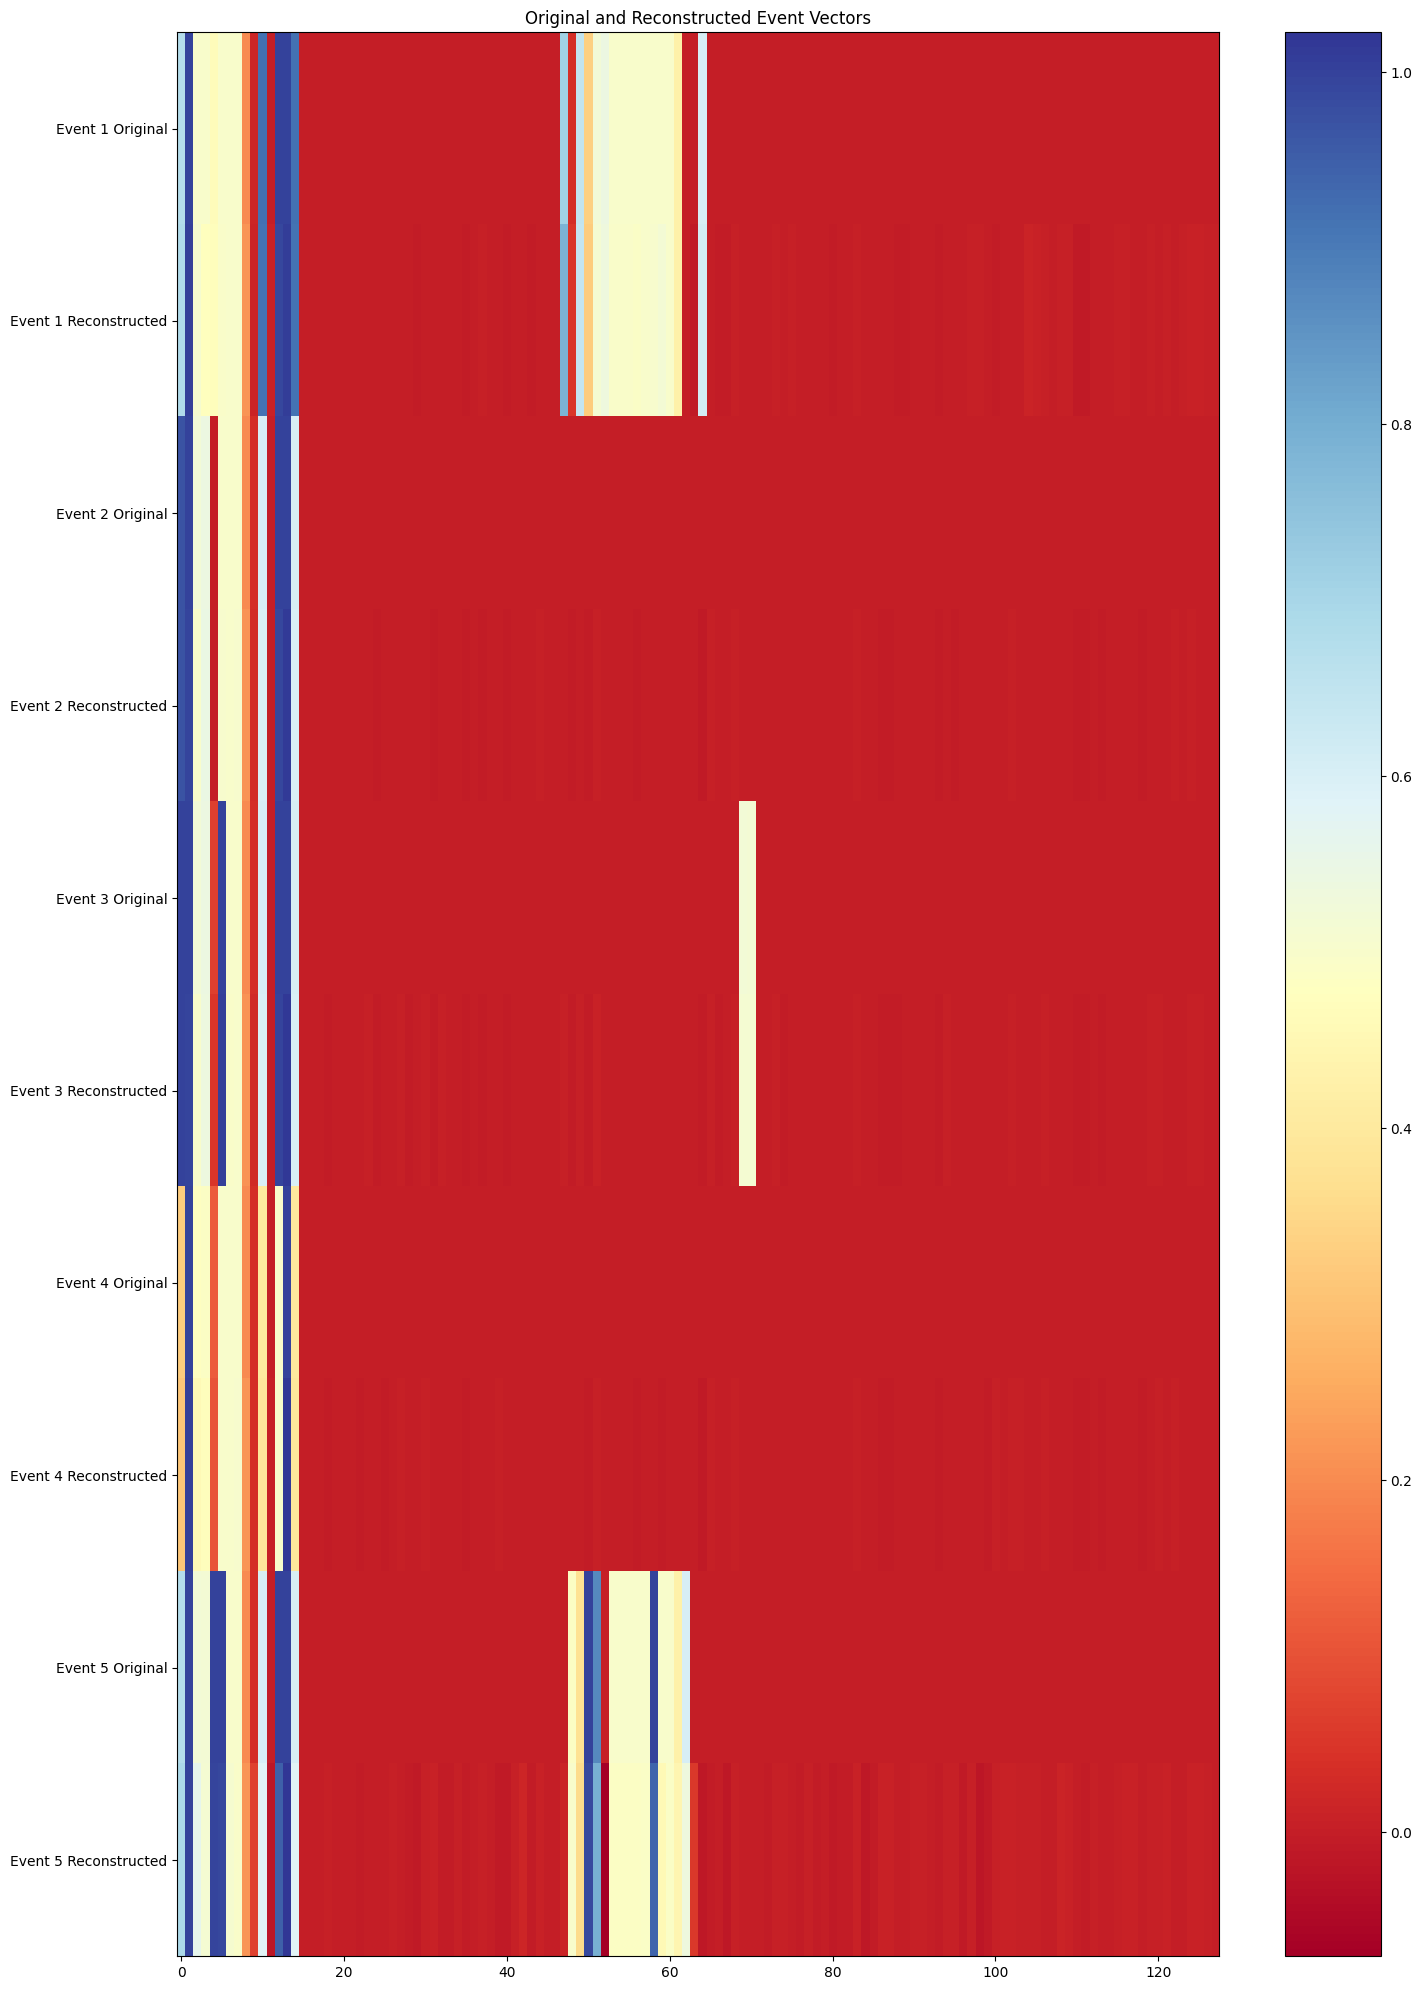


Detailed Vector Values:
--------------------------------------------------

Event 1 Original:
[0.6764706  1.         0.5        0.5        0.463445   0.5
 0.5        0.5        0.2        0.01666667 0.92       0.
 1.         1.         0.92       0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.71428573
 0.03450041 0.6464229  0.33333334 0.5208333  0.54125    0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.42857143 0.         0.         0.6        0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.      

In [ ]:
# compare_reconstructions(model_mse, X_tensor)
compare_reconstructions(model_mse, sample_inputs)

### From L1 loss

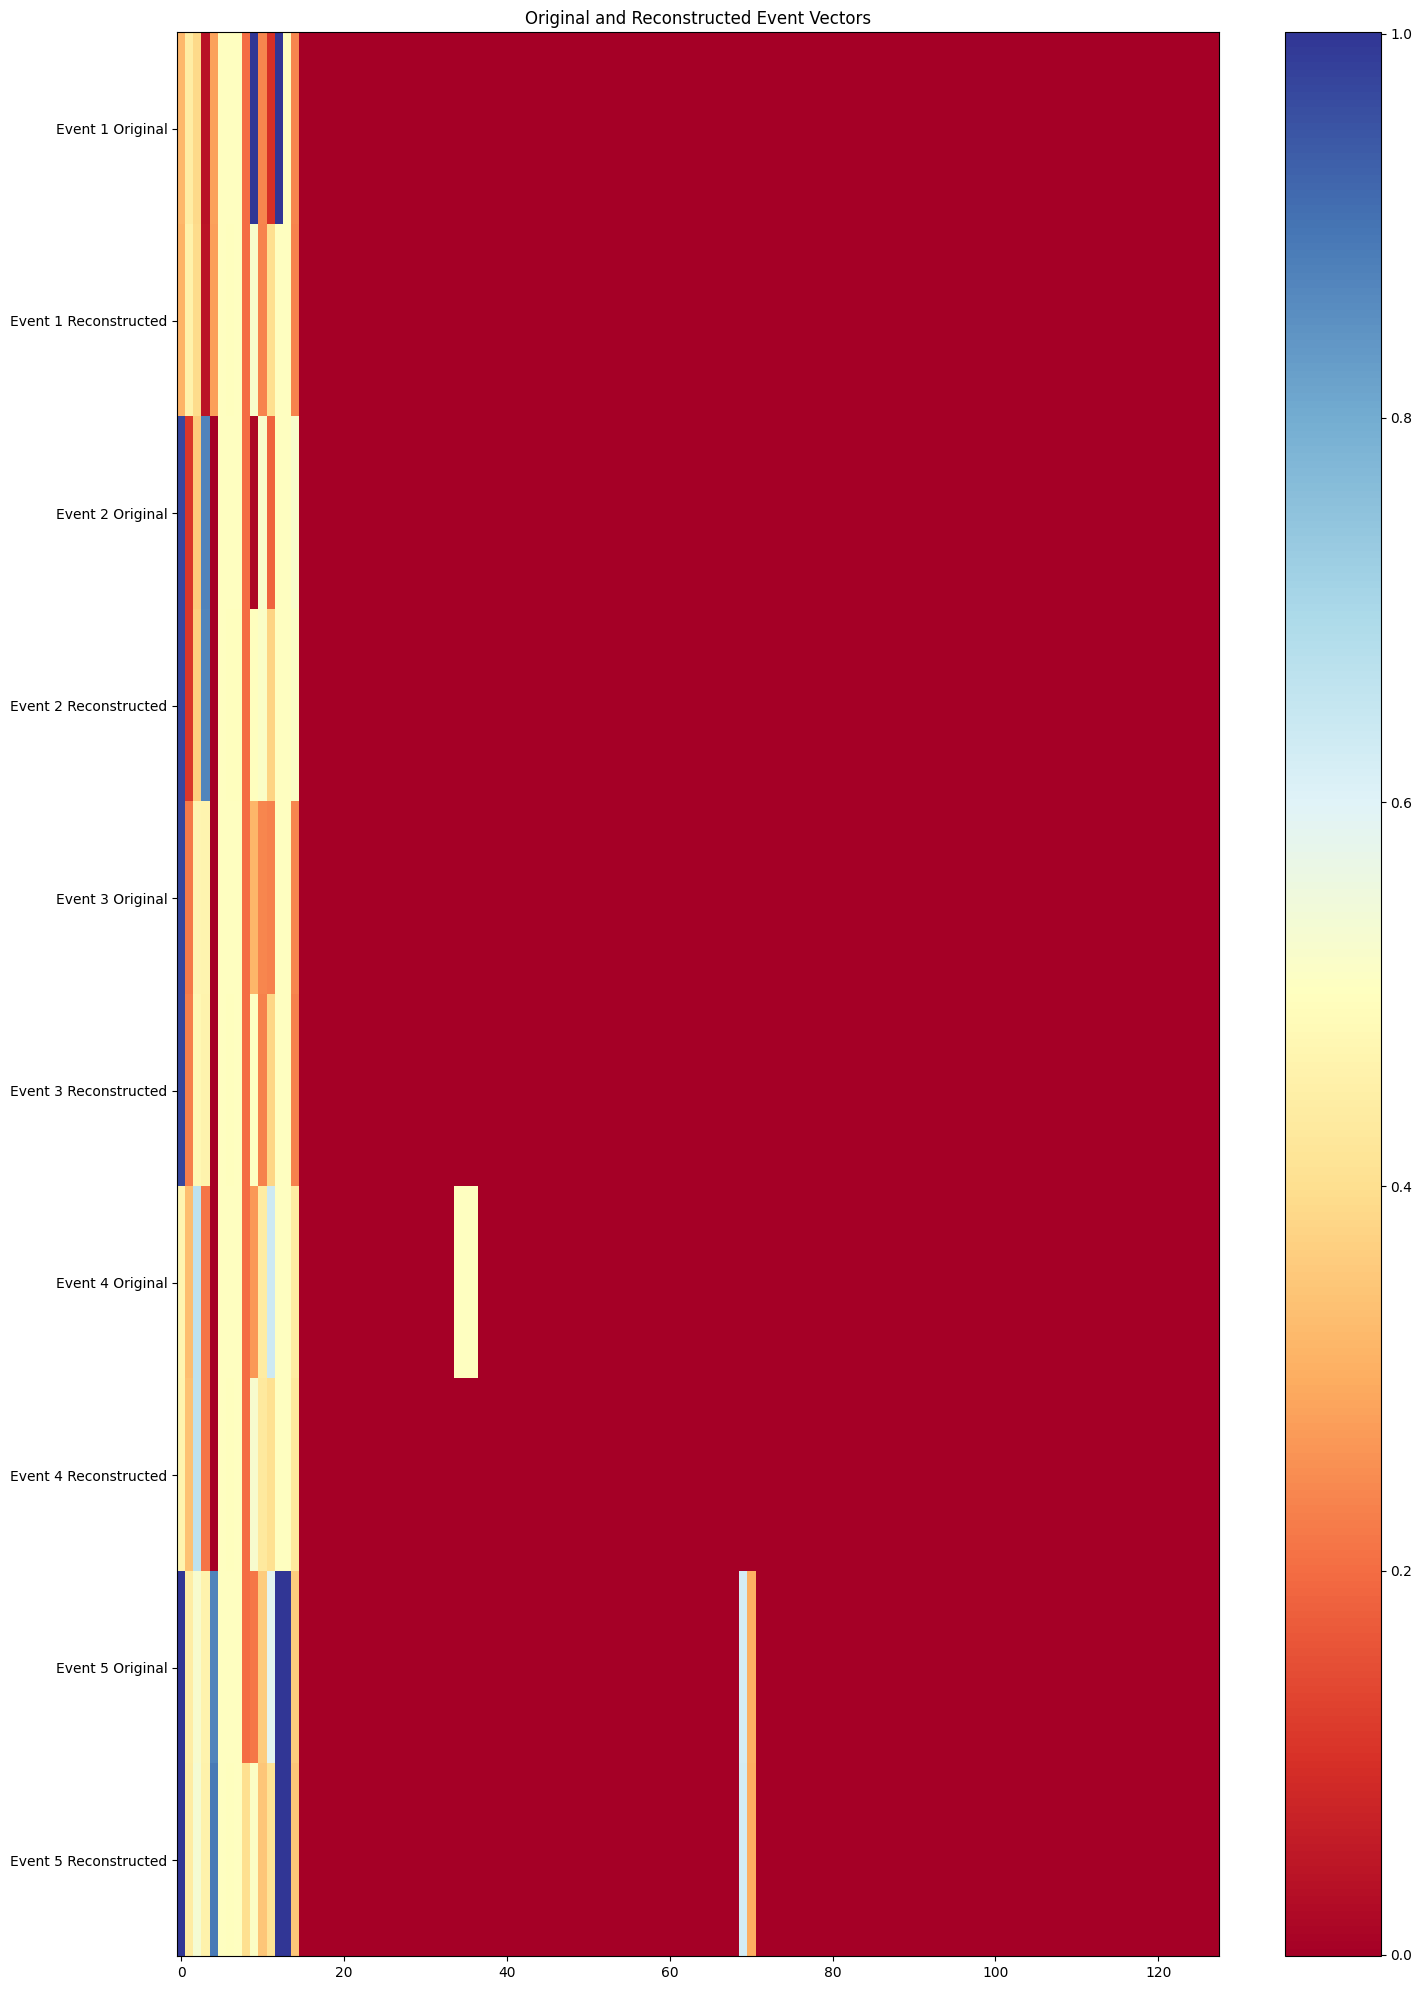


Detailed Vector Values:
--------------------------------------------------

Event 1 Original:
[0.32352942 0.44444445 0.38666666 0.04       0.28365833 0.5
 0.5        0.5        0.2        1.         0.24       0.1
 1.         0.5        0.24       0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.    

In [ ]:
# compare_reconstructions(model_l1, X_tensor)
compare_reconstructions(model_l1, sample_inputs)

## Dimension reduction and visualization

Creating numpy array of all event types

In [ ]:
import numpy as np

event_types = [
    "Ball Receipt",
    "Ball Recovery",
    "Dispossessed",
    "Duel",
    "Camera On",
    "Block",
    "Offside",
    "Clearance",
    "Interception",
    "Dribble",
    "Shot",
    "Pressure",
    "Half Start",
    "Substitution",
    "Own Goal Against",
    "Foul Won",
    "Foul Committed",
    "Goal Keeper",
    "Bad Behaviour",
    "Own Goal For",
    "Player On",
    "Player Off",
    "Shield",
    "Pass",
    "50/50",
    "Half End",
    "Starting XI",
    "Tactical Shift",
    "Error",
    "Miscontrol",
    "Dribbled Past",
    "Injury Stoppage",
    "Referee Ball-Drop",
    "Carry"
]

event_types_array = np.array(event_types)

In [ ]:
from sklearn.metrics import silhouette_score
from matplotlib import cm

def plot_embedding(embeddings_2d, event_types):
    """
    Plot the 2D embeddings colored by event type.

    Parameters:
    -----------
    embeddings_2d : np.array
        2D embeddings from t-SNE, UMAP, or other dimensionality reduction
    event_types : np.array
        Array of event type labels
    """
    # Identify unique event types
    unique_types = np.unique(event_types)
    num_unique = len(unique_types)

    # Create a color map with enough discrete colors for each event type
    cmap = cm.get_cmap('hsv', 34)

    # Create figure and axis
    plt.figure(figsize=(15, 10))

    # Plot each event type with a unique color
    for i, event_type in enumerate(unique_types):
        # Mask for the current event_type
        mask = (event_types == event_type)

        # Get the i-th color from the colormap
        color = cmap(i)

        # Plot with that color
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            color=[color],
            label=event_type,
            alpha=0.6
        )

    # Calculate silhouette score
    silhouette = silhouette_score(embeddings_2d, event_types)

    # Add title and axis labels
    plt.title('Event Type Embeddings', fontsize=14)
    plt.xlabel(f'Dimension 1 (Silhouette Score: {silhouette:.3f})', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)

    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout to prevent legend cutoff
    plt.tight_layout()

    # Save and show plot
    plt.savefig('embeddings_visualization.png', bbox_inches='tight', dpi=300)
    plt.show()


In [ ]:
embeddings_l1 = get_embeddings(model_l1, test_loader)
embeddings_mse = get_embeddings(model_mse, test_loader)

Generating embeddings: 100%|██████████| 5499/5499 [00:11<00:00, 483.52it/s]


In [ ]:
print(embeddings_l1.shape)
print(embeddings_mse.shape)

(351925, 32)
(351925, 32)


### Reducing the size of embeddings for faster inference.

In [ ]:
import numpy as np

def sample_embeddings(embeddings, event_types, n_samples=5000):
    """
    Randomly sample a subset of embeddings and their corresponding event types.

    Parameters:
    -----------
    embeddings : np.array
        Original embeddings array of shape (n_samples, n_features)
    event_types : np.array
        Original event types array
    n_samples : int
        Number of samples to keep

    Returns:
    --------
    sampled_embeddings : np.array
        Sampled embeddings
    """
    if len(embeddings) <= n_samples:
        return embeddings, embeddings[:, 0]

    # Generate random indices
    indices = np.random.choice(len(embeddings), n_samples, replace=False)

    # Sample embeddings
    sampled_embeddings = embeddings[indices]
    sampled_embeddings_types = event_types[indices]

    print(f"Reduced dataset from {len(embeddings)} to {n_samples} samples")

    return sampled_embeddings, sampled_embeddings_types

In [ ]:
n_samples = 5000
sampled_embeddings_l1, sampled_embeddings_types_l1 = sample_embeddings(embeddings_l1, embeddings_event_types, n_samples)
sampled_embeddings_mse, sampled_embeddings_types_mse = sample_embeddings(embeddings_mse, embeddings_event_types, n_samples)

Reduced dataset from 351925 to 5000 samples
Reduced dataset from 351925 to 5000 samples


### t-SNE on MSE model

Performing t-SNE...


<ipython-input-30-6d4c2ee31b16>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hsv', 34)


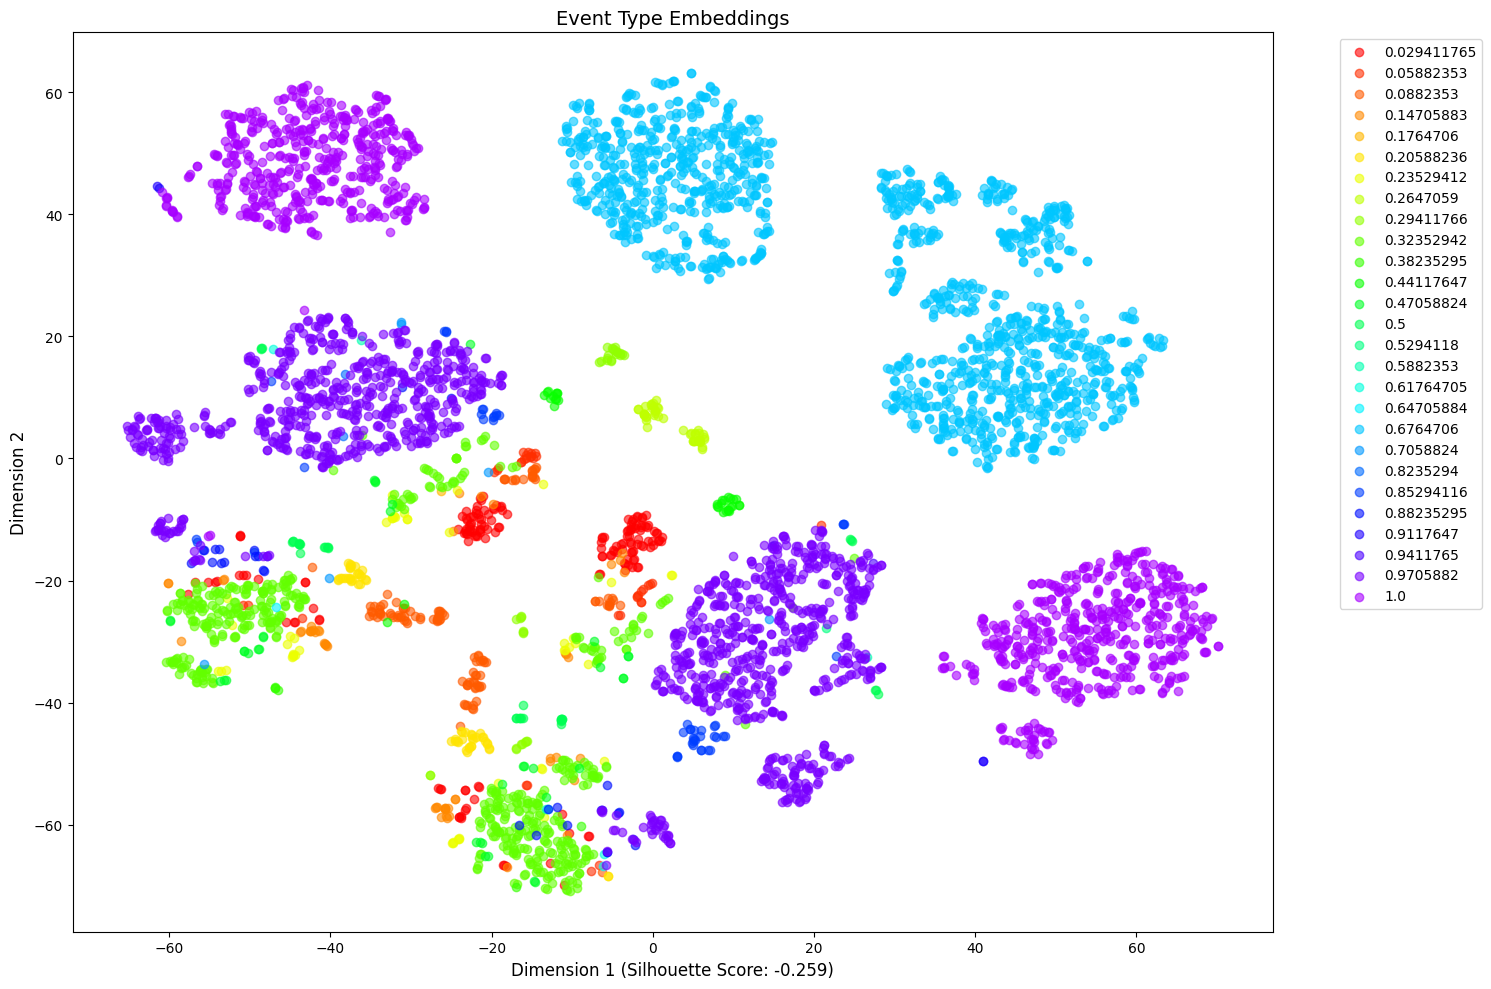

In [ ]:
from sklearn.manifold import TSNE

print("Performing t-SNE...")
perplexity=30
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
tsne_result = tsne.fit_transform(sampled_embeddings_mse)
plot_embedding(tsne_result, sampled_embeddings_types_mse)

### t-SNE on L1 model

Performing t-SNE...


<ipython-input-30-6d4c2ee31b16>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hsv', 34)


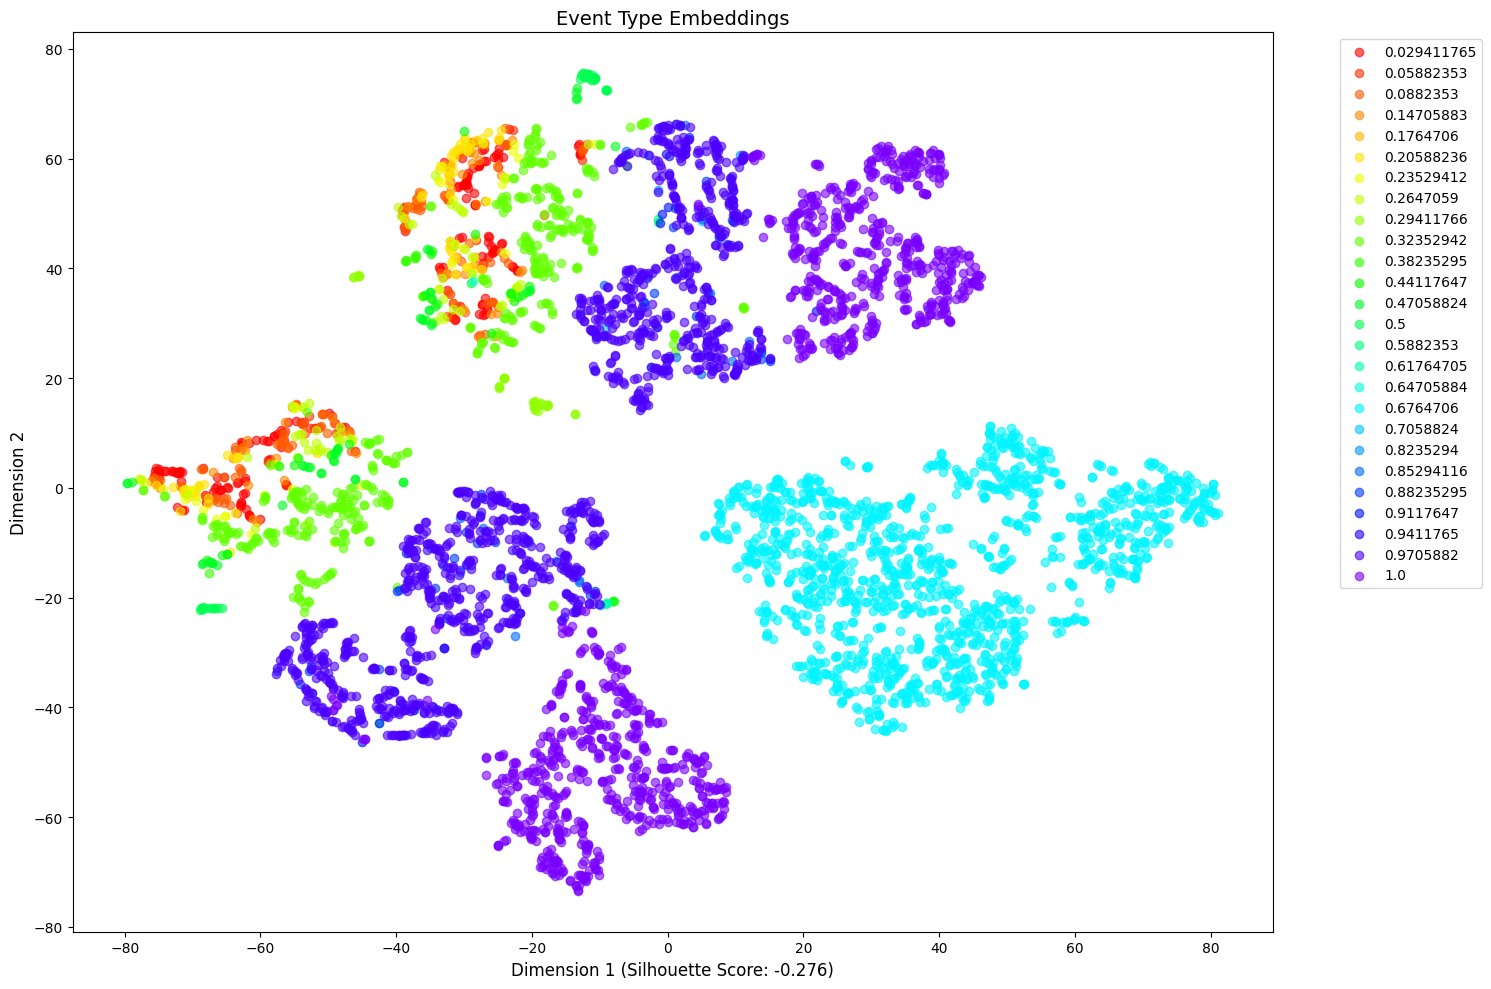

In [ ]:
from sklearn.manifold import TSNE

print("Performing t-SNE...")
perplexity=30
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
tsne_result = tsne.fit_transform(sampled_embeddings_l1)
plot_embedding(tsne_result, sampled_embeddings_types_l1)

### UMAP

Downgrade numpy

In [ ]:
!pip uninstall numpy -y
!pip cache purge
!pip install numpy==1.26.4 --force-reinstall --no-deps

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Files removed: 6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 69.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
print(np.__version__)

1.26.4


In [ ]:
import sys

# Trying to remove references to NumPy
mods_to_delete = [m for m in sys.modules if 'numpy' in m]
for m in mods_to_delete:
    del sys.modules[m]

### UMAP on MSE model

Performing UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-30-6d4c2ee31b16>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hsv', 34)


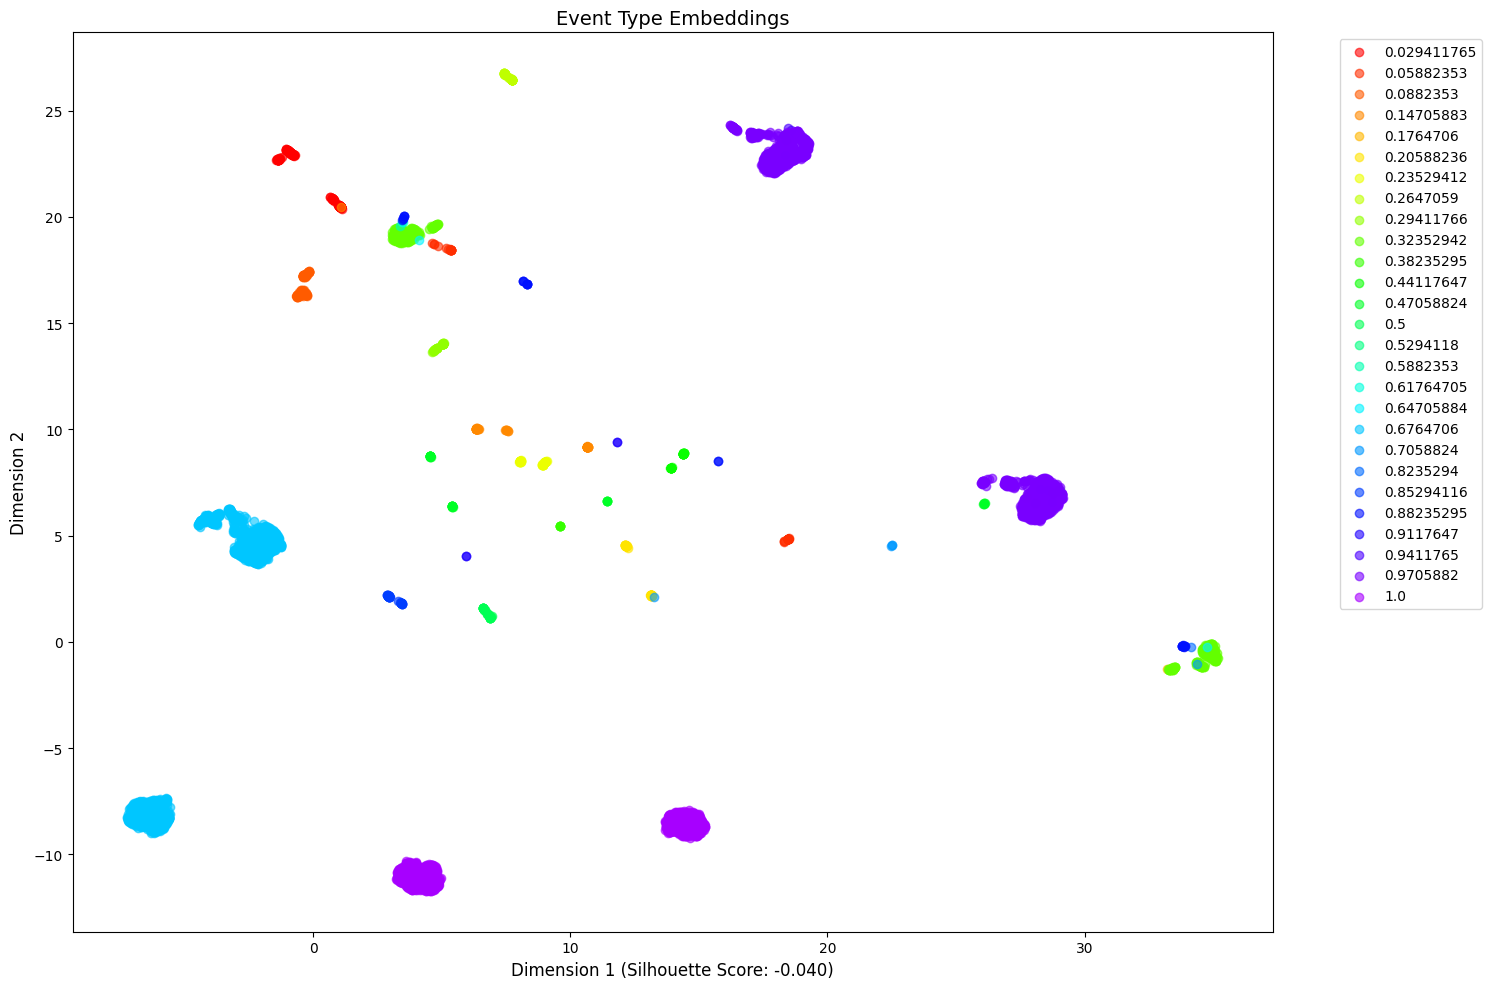

In [ ]:
print("Performing UMAP...")
perplexity=30
umap = UMAP(n_components=2, n_neighbors=perplexity,
            target_metric='categorical', target_weight=0.5,
            random_state=42)
umap_result = umap.fit_transform(sampled_embeddings_mse, y=sampled_embeddings_types_mse)
plot_embedding(umap_result, sampled_embeddings_types_mse)

### UMAP on L1 model

1.26.4
Performing UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-30-6d4c2ee31b16>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hsv', 34)


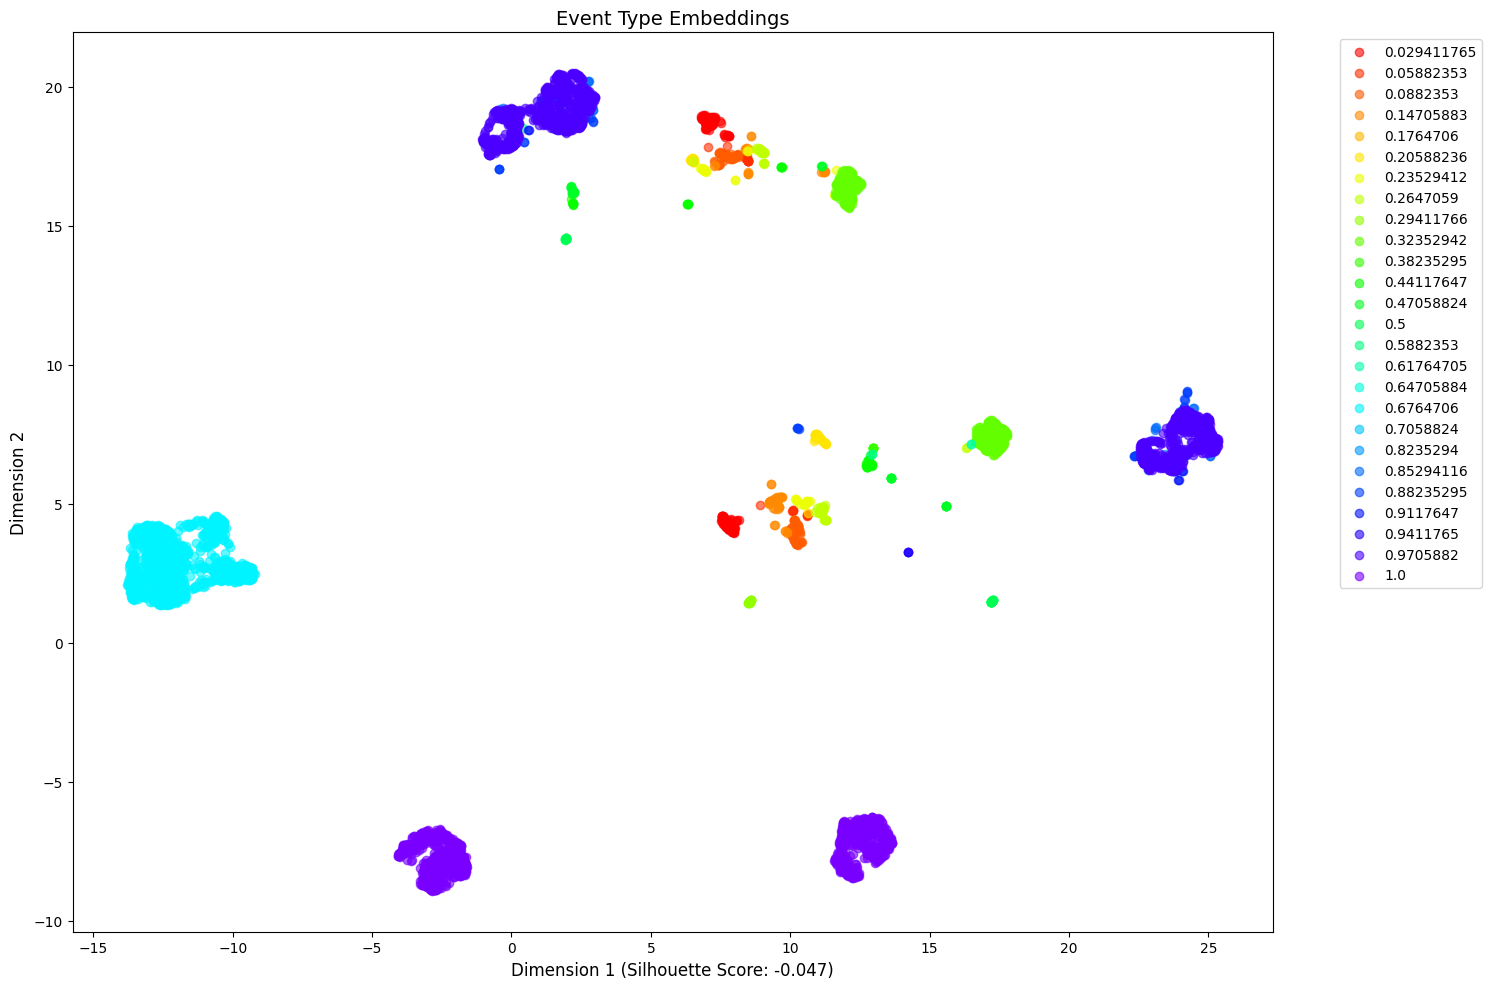

In [ ]:
import numpy
print(numpy.__version__)
from umap import UMAP

print("Performing UMAP...")
perplexity=30
umap = UMAP(n_components=2, n_neighbors=perplexity,
            target_metric='categorical', target_weight=0.5,
            random_state=42)
umap_result = umap.fit_transform(sampled_embeddings_l1, y=sampled_embeddings_types_l1)
plot_embedding(umap_result, sampled_embeddings_types_l1)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print("Performing LDA...")
lda = LinearDiscriminantAnalysis(n_components=2)
lda_result = lda.fit_transform(sampled_embeddings, sampled_embeddings_types)
plot_embedding(lda_result, event_types_array)

Performing LDA...


ValueError: Unknown label type: (array([0.02941176, 0.9705882 , 0.9705882 , ..., 0.9705882 , 0.9705882 ,
       0.32352942], shape=(5000,), dtype=float32),)